In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/Satellite_Property_Project/data/images_train'
TRAIN_PATH = '/content/drive/MyDrive/Satellite_Property_Project/data/train(1).xlsx'
TEST_PATH = '/content/drive/MyDrive/Satellite_Property_Project/data/test2.xlsx'

df_train = pd.read_excel(TRAIN_PATH, dtype={'id': str})
df_test = pd.read_excel(TEST_PATH, dtype={'id': str})

## **EDA**

In [ ]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (16209, 21)
Test shape: (5404, 20)


Checking for any missing values

In [ ]:
df_train.isnull().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


Checking for any duplicate rows

In [ ]:
print(df_train.duplicated().sum())

0


Analysing the dataset stats

In [ ]:
df_train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.620900e+04,16209.00000,16209.000000,16209.000000,1.620900e+04,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000
mean,5.374703e+05,3.36782,2.113054,2073.274601,1.486767e+04,1.498828,0.006971,0.234253,3.407860,7.652971,1784.754396,288.520205,1971.152755,82.738108,98077.974767,47.560707,-122.214003,1983.152261,12735.572707
std,3.603036e+05,0.93327,0.765242,907.009491,3.882570e+04,0.543032,0.083206,0.763152,0.651553,1.171050,821.820844,438.598910,29.372698,397.861148,53.355282,0.138340,0.140093,681.905161,26933.162012
min,7.500000e+04,0.00000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,651.000000
25%,3.200000e+05,3.00000,1.500000,1430.000000,5.004000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472500,-122.328000,1480.000000,5098.000000
50%,4.500000e+05,3.00000,2.250000,1910.000000,7.599000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572400,-122.230000,1840.000000,7620.000000
75%,6.400000e+05,4.00000,2.500000,2550.000000,1.063100e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.000000,10053.000000
max,7.700000e+06,33.00000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Adding an additional column which contains the image path for that particular row for easy loading of files later on.

In [ ]:
def get_image_path(row, image_dir):
    filename = f"{row['id']}.jpg"
    return os.path.join(image_dir, filename)

def check_image_exists(row):
    return os.path.exists(get_image_path(row, IMAGE_DIR))

print("Checking for missing images..")
df_train['img_exists'] = df_train.apply(check_image_exists, axis=1)
df_test['img_exists'] = df_test.apply(check_image_exists, axis=1)

df_train_clean = df_train[df_train['img_exists'] == True].copy()
df_test_clean = df_test[df_test['img_exists'] == True].copy()

df_train_clean['img_path'] = df_train_clean.apply(lambda x: get_image_path(x, IMAGE_DIR), axis=1)
df_test_clean['img_path'] = df_test_clean.apply(lambda x: get_image_path(x, IMAGE_DIR), axis=1)

print(f"Cleaned Train shape: {df_train_clean.shape}")
print(f"Cleaned Test shape: {df_test_clean.shape}")
print(f"Lost {len(df_train) - len(df_train_clean)} training rows due to missing images.")


Checking for missing images..
Cleaned Train shape: (16207, 23)
Cleaned Test shape: (5404, 22)
Lost 2 training rows due to missing images.


Checking for price column distribution

Text(0.5, 1.0, 'Price Distribution')

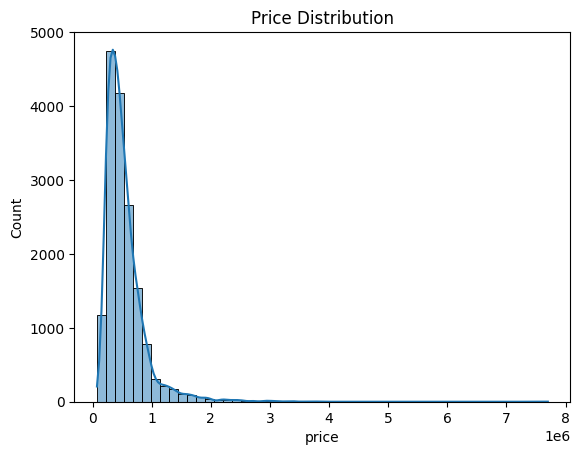

In [ ]:
sns.histplot(df_train_clean["price"], bins=50, kde=True)
plt.title("Price Distribution")

Log transforming the price column

Text(0.5, 1.0, 'Log Transformed Price Distribution')

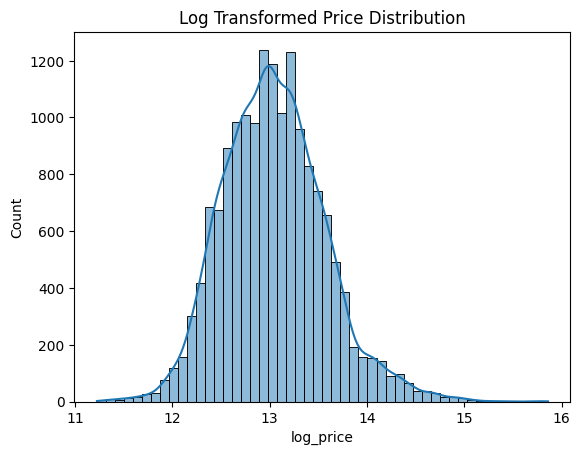

In [ ]:
df_train_clean["log_price"] = np.log1p(df_train_clean["price"])

sns.histplot(df_train_clean["log_price"], bins=50, kde=True)
plt.title("Log Transformed Price Distribution")

In [ ]:
df_train_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,img_exists,img_path,log_price
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,1961,0,98055,47.4362,-122.187,1660,9240,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.501142
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,1992,0,98031,47.4034,-122.187,1720,3605,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.409018
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,1994,0,98003,47.2704,-122.313,1870,7455,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.206078
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,2009,0,98027,47.5321,-122.073,1240,750,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.772806
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,1994,0,98042,47.3715,-122.074,1590,8071,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.354497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,5272200045,20141113T000000,378000,3,1.50,1000,6914,1.0,0,0,...,1947,0,98125,47.7144,-122.319,1000,6947,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.842652
16205,9578500790,20141111T000000,399950,3,2.50,3087,5002,2.0,0,0,...,2014,0,98023,47.2974,-122.349,2927,5183,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.899097
16206,7202350480,20140930T000000,575000,3,2.50,2120,4780,2.0,0,0,...,2004,0,98053,47.6810,-122.032,1690,2650,True,/content/drive/MyDrive/Satellite_Property_Proj...,13.262127
16207,1723049033,20140620T000000,245000,1,0.75,380,15000,1.0,0,0,...,1963,0,98168,47.4810,-122.323,1170,15000,True,/content/drive/MyDrive/Satellite_Property_Proj...,12.409018


**Creating functions for certain checks that are required to conduct on the dataset**

In [ ]:
def sqft_consistency_check(df, name="dataset"):
    df['sqft_check'] = df['sqft_above'] + df['sqft_basement']
    mismatch = df[df['sqft_living'] != df['sqft_check']]

    if len(mismatch) > 0:
        print(f"Note ({name}): {len(mismatch)} rows have inconsistent sqft measurements. "
              f"Trusting 'sqft_living'.")

    return df

In [ ]:
def check_renovation_year(df, name="dataset"):
    wrong_data = df[
        (df['yr_renovated'] != 0) &
        (df['yr_renovated'] < df['yr_built'])
    ]

    if len(wrong_data) > 0:
        print(
            f"Note ({name}): {len(wrong_data)} rows have "
            f"yr_renovated earlier than yr_built. Treating as not renovated."
        )

        df.loc[wrong_data.index, 'yr_renovated'] = 0

    return df


In [ ]:
def check_living_vs_lot(df, name="dataset"):
    wrong_data = df[
        (df['sqft_living'] > df['sqft_lot']) &
        (df['sqft_basement'] == 0) &
        (df['floors'] == 1)
    ]

    if len(wrong_data) > 0:
        print(
            f"Note ({name}): {len(wrong_data)} rows where "
            f"sqft_living > sqft_lot for 1-floor homes without basement. "
            f"Dropping these rows."
        )

        df = df.drop(index=wrong_data.index)

    return df


In [ ]:
def check_built_after_sale(df, name="dataset"):
    wrong_data = df[df['sale_year'] < df['yr_built']]

    if len(wrong_data) > 0:
        print(
            f"Note ({name}): {len(wrong_data)} rows where "
            f"yr_built is after sale year. Dropping these rows."
        )

        df = df.drop(index=wrong_data.index)

    return df


Running those functions on the dataset and checking for any discrepencies

In [ ]:
df_train_clean['log_price'] = np.log1p(df_train_clean['price'])

df_train_clean['date'] = pd.to_datetime(df_train_clean['date'])
df_test_clean['date'] = pd.to_datetime(df_test_clean['date'])

df_train_clean['sale_year'] = df_train_clean['date'].dt.year
df_train_clean['sale_month'] = df_train_clean['date'].dt.month

df_test_clean['sale_year'] = df_test_clean['date'].dt.year
df_test_clean['sale_month'] = df_test_clean['date'].dt.month

df_train_clean['house_age'] = df_train_clean['sale_year'] - df_train_clean['yr_built']
df_test_clean['house_age'] = df_test_clean['sale_year'] - df_test_clean['yr_built']

df_train_clean = check_renovation_year(df_train_clean, "train")

df_train_clean['is_renovated'] = (df_train_clean['yr_renovated'] > 0).astype(int)
df_test_clean['is_renovated'] = (df_test_clean['yr_renovated'] > 0).astype(int)

df_train_clean = sqft_consistency_check(df_train_clean, "train")

df_train_clean = check_built_after_sale(df_train_clean, "train")

df_train_clean = check_living_vs_lot(df_train_clean, "train")

Note (train): 11 rows where yr_built is after sale year. Dropping these rows.


Contructing a correlational matrix

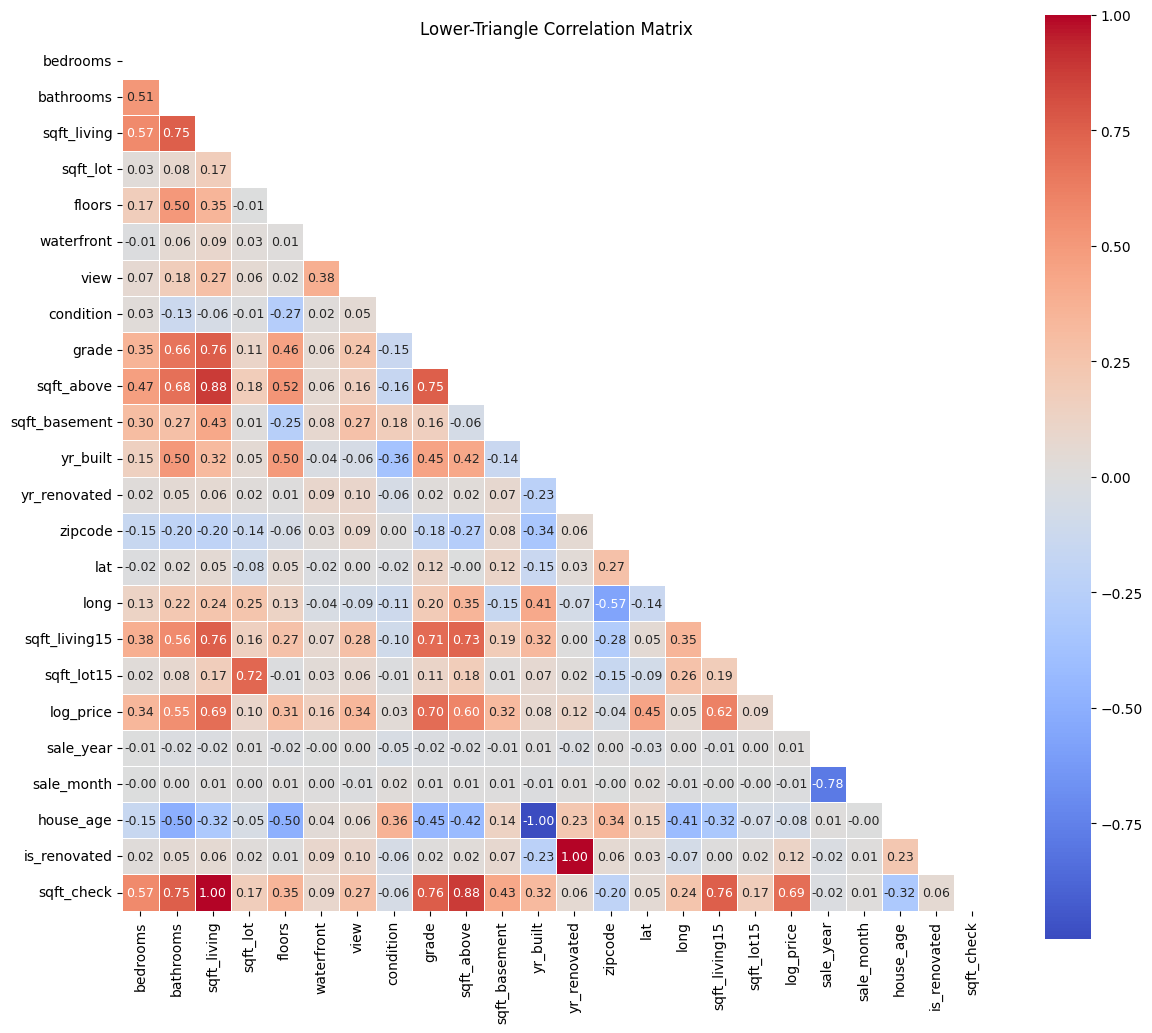

In [ ]:
corr = df_train_clean.drop(columns=["id", "price",'date','img_path','img_exists']).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14,12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},
    square=True,
    linewidths=0.5
)
plt.title("Lower-Triangle Correlation Matrix")
plt.show()

Visualising how does waterfront and view affect prices

/tmp/ipython-input-1648804028.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_clean, x='waterfront', y='log_price', ax=axes[0], palette='coolwarm')
/tmp/ipython-input-1648804028.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_clean, x='view', y='log_price', ax=axes[1], palette='viridis')


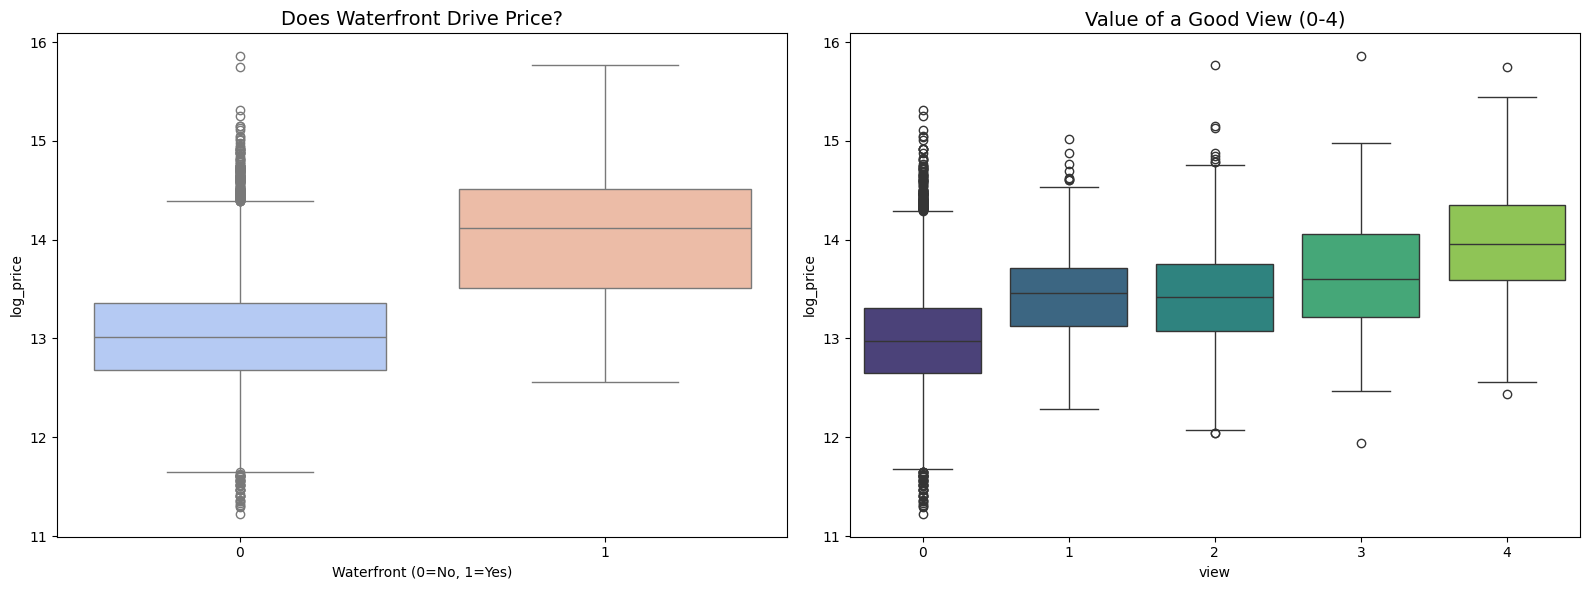

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Waterfront Effect
sns.boxplot(data=df_train_clean, x='waterfront', y='log_price', ax=axes[0], palette='coolwarm')
axes[0].set_title("Does Waterfront Drive Price?", fontsize=14)
axes[0].set_xlabel("Waterfront (0=No, 1=Yes)")

# View Effect
sns.boxplot(data=df_train_clean, x='view', y='log_price', ax=axes[1], palette='viridis')
axes[1].set_title("Value of a Good View (0-4)", fontsize=14)

plt.tight_layout()
plt.show()

Checking for wealth clusters

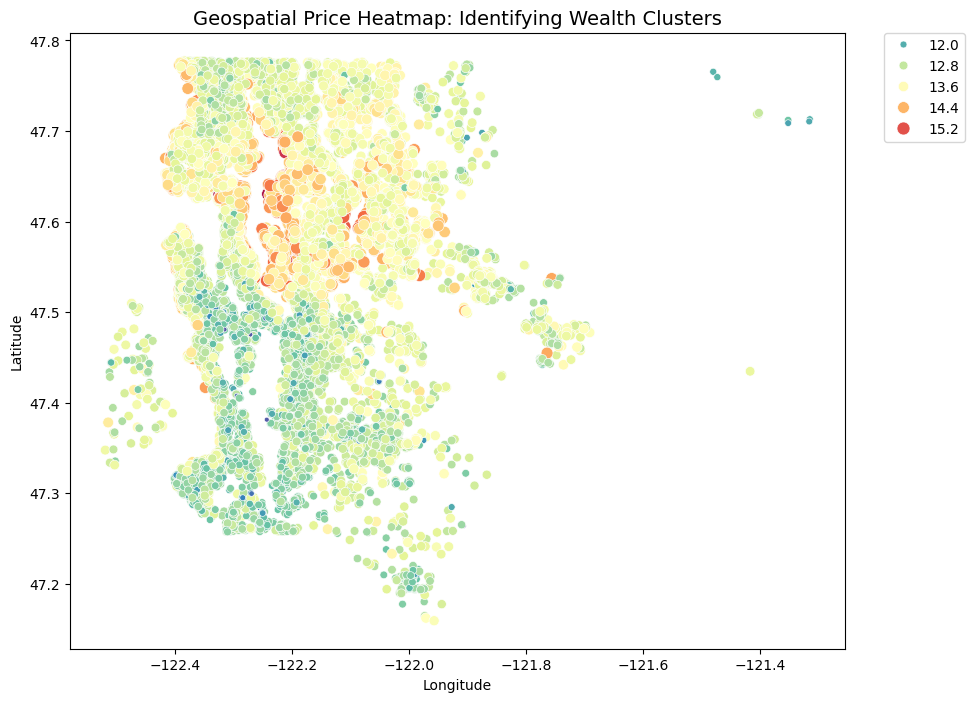

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_train_clean, x='long', y='lat',
    hue='log_price', palette='Spectral_r', size='log_price', sizes=(10, 100), alpha=1
)
plt.title("Geospatial Price Heatmap: Identifying Wealth Clusters", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Checking the effect of grade on prices on the basis of sqft_living

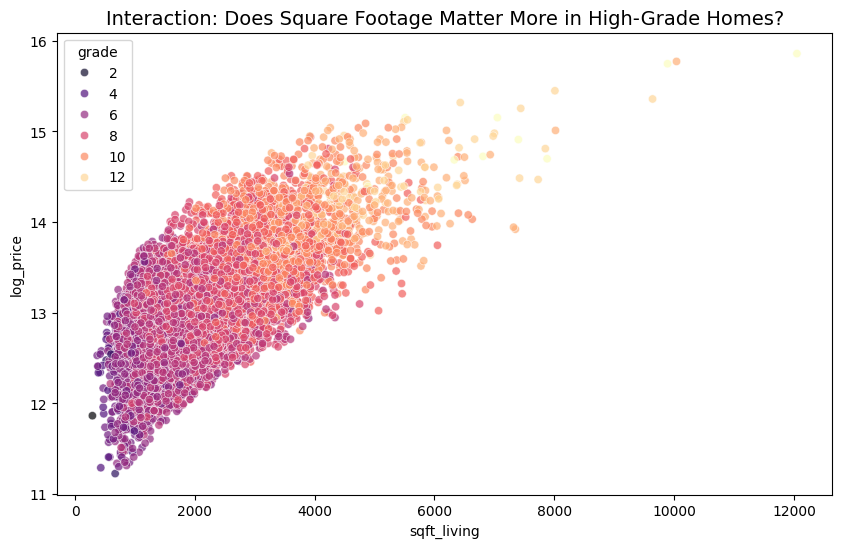

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_train_clean, x='sqft_living', y='log_price',
    hue='grade', palette='magma', alpha=0.7
)
plt.title("Interaction: Does Square Footage Matter More in High-Grade Homes?", fontsize=14)
plt.show()

Dropping temporary columns

In [ ]:
cols_to_drop = ['sale_year', 'sale_month']

df_train_clean = df_train_clean.drop(columns=cols_to_drop)
df_test_clean = df_test_clean.drop(columns=cols_to_drop)

In [ ]:
df_train_clean = df_train_clean.drop(columns=['price','sqft_check'])

In [ ]:
df_train_clean.dtypes

,0
id,object
date,datetime64[ns]
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64
condition,int64


# Constructing Baseline Models on tabular only data

In [ ]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
            'lat', 'long', 'sqft_living15', 'sqft_lot15','house_age', 'is_renovated','zipcode']

X = df_train_clean[features]
y = df_train_clean['log_price']

print(f"Features used ({len(features)}): {features}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train Size: {X_train.shape[0]}, Validation Size: {X_val.shape[0]}")

Features used (17): ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'is_renovated', 'zipcode']
Train Size: 12956, Validation Size: 3240


Starting Model Shootout...
------------------------------------------------------------
Model Name                | RMSE ($)        | R2 Score  
------------------------------------------------------------
Linear Regression         | $179,896        | 0.7406
Ridge Regression          | $175,887        | 0.7521
XGBoost                   | $109,474        | 0.9039
------------------------------------------------------------
 WINNER: XGBoost with RMSE $109,474


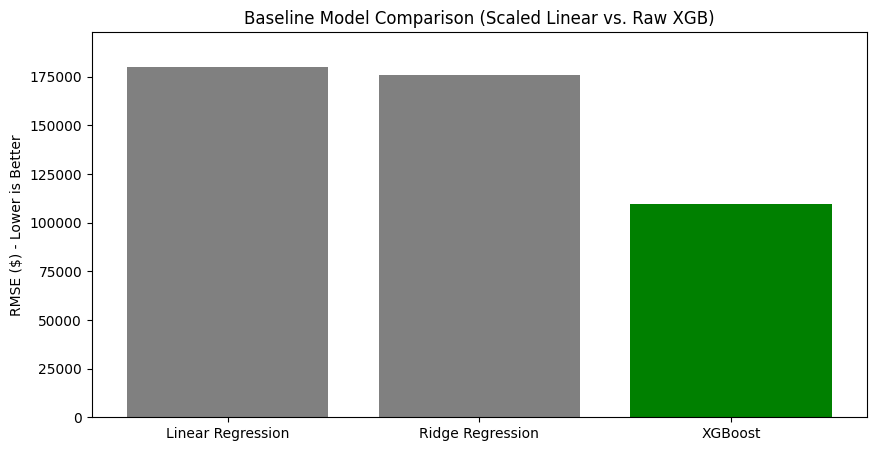

In [ ]:
numerical_cols=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
                'lat', 'long', 'sqft_living15', 'sqft_lot15','house_age', 'is_renovated']

categorical_cols = ['zipcode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipelines = {
    "Linear Regression": Pipeline([('prep', preprocessor), ('model', LinearRegression())]),
    "Ridge Regression": Pipeline([('prep', preprocessor), ('model', Ridge(alpha=1.0))]),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
}

results = {}
best_model_name = ""
best_rmse = float('inf')

print("Starting Model Shootout...")
print("-" * 60)
print(f"{'Model Name': <25} | {'RMSE ($)': <15} | {'R2 Score': <10}")
print("-" * 60)

for name, model in pipelines.items():
    if name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        model.fit(X_train, y_train)

    preds_log = model.predict(X_val)
    preds_dollar = np.expm1(preds_log)
    y_val_dollar = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_dollar, preds_dollar))
    r2 = r2_score(y_val_dollar, preds_dollar)

    results[name] = rmse
    print(f"{name: <25} | ${rmse:,.0f}        | {r2:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

print("-" * 60)
print(f" WINNER: {best_model_name} with RMSE ${best_rmse:,.0f}")

plt.figure(figsize=(10, 5))
bars = plt.bar(results.keys(), results.values(), color=['gray', 'gray', 'green'])
plt.ylabel('RMSE ($) - Lower is Better')
plt.title('Baseline Model Comparison (Scaled Linear vs. Raw XGB)')
plt.ylim(0, max(results.values()) * 1.1)
plt.show()

In [ ]:
df_train_clean.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'img_exists', 'img_path', 'log_price',
       'house_age', 'is_renovated'],
      dtype='object')

Saving the processed files as csv.

In [ ]:
df_train_clean.to_csv('/content/drive/MyDrive/Satellite_Property_Project/train_processed.csv', index=False)
df_test_clean.to_csv('/content/drive/MyDrive/Satellite_Property_Project/test_processed.csv', index=False)
print("Preprocessing complete. Files saved.")

Preprocessing complete. Files saved.
